In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.dates import DateFormatter
#import sklearn.feature_selection

from load_wastewater_data import load_systems_data

# Update rcParams to set the default font to Times New Roman
sns.set_style(style='white')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [80]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

resolution = "3_min_resolution" 
rain_scenario = "KeinRegen" # one of KeinRegen, Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_0_0001", "constant_decay_0_025"

In [81]:
plot_path = f"../plots/wastewater_model/correlation"
os.makedirs(os.path.join(plot_path), exist_ok=True)
file_name_prefix = f"{resolution}_{rain_scenario}_{degradation_setting}"

Load data

In [82]:
df_wastewater = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="concentrations")

df_wastewater["hours"] = df_wastewater["minutes"]/60
df_wastewater = df_wastewater[[int(x)==x for x in df_wastewater.hours]] # only subselect full hours

In [83]:
infection_model_output_path = f"../../preprocessing/preprocessed_data/infection_model/{experiment_series}"
df_prevalence = pd.read_csv(os.path.join(infection_model_output_path, "console_output_summarized.csv"))

In [84]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method = "spearman")
    #v1 = datax.values
    #v2 = datay.shift(lag).values
    
    #v1 = v1[np.logical_not(np.isnan(v2))].reshape(-1, 1)
    #v2 = v2[np.logical_not(np.isnan(v2))].reshape(-1, 1)
    
    #res = sklearn.feature_selection.mutual_info_regression(v1, v2)
    
    #return res.item()

In [85]:
def get_crosscorr_for_one_station(df_combined, sampling_location, lags_in_hours):
    df_combined_sub = df_combined.loc[df_combined.sampling_point==sampling_location, :].sort_values("hours")
    return [crosscorr(df_combined_sub["COVID_copies/l"], df_combined_sub["I_total"], lag) for lag in lags_in_hours]

In [86]:
lag_in_hours = 36 
print(f"Lag in hours: {lag_in_hours}")
df_wastewater_sim1 = df_wastewater.loc[df_wastewater['memilio_id'] == 1]
df_prevalence_sim1 = df_prevalence.loc[df_prevalence['memilio_id'] == 1]
df_combined_sim1 = df_wastewater_sim1.merge(df_prevalence_sim1, left_on="hours", right_on="time", how="left")
df_combined_sim1.head()
correlations = get_crosscorr_for_one_station(df_combined_sim1, "16", [-lag_in_hours, 0, lag_in_hours])

Lag in hours: 36


In [87]:
# Define variables
sampling_location = "16"
lag = 36

df_wastewater_sub = df_combined_sim1.loc[df_combined_sim1['sampling_point'] == sampling_location].sort_values("hours")
df_wastewater_sub["time_in_days"] = df_wastewater_sub["hours"]/24
df_prevalence_sim1["time_in_days"] = df_prevalence_sim1["time"]/24


/var/folders/h0/9nm34gsx7x1d6tknzfpscvsr0000gn/T/ipykernel_20777/2481195407.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prevalence_sim1["time_in_days"] = df_prevalence_sim1["time"]/24


In [88]:
df_prevalence_sim1["time_in_days_plus_lag"] = df_prevalence_sim1["time_in_days"] + lag/24
df_prevalence_sim1["time_in_days_minus_lag"] = df_prevalence_sim1["time_in_days"] - lag/24

min_time = df_prevalence_sim1["time_in_days"].min()
max_time = df_prevalence_sim1["time_in_days"].max()

/var/folders/h0/9nm34gsx7x1d6tknzfpscvsr0000gn/T/ipykernel_20777/230434999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prevalence_sim1["time_in_days_plus_lag"] = df_prevalence_sim1["time_in_days"] + lag/24
/var/folders/h0/9nm34gsx7x1d6tknzfpscvsr0000gn/T/ipykernel_20777/230434999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prevalence_sim1["time_in_days_minus_lag"] = df_prevalence_sim1["time_in_days"] - lag/24


In [89]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [90]:
df_prevalence_sim1.time_in_days.unique()[df_prevalence_sim1.time_in_days.unique()>2.2][1:20]

array([2.25      , 2.29166667, 2.33333333, 2.375     , 2.41666667,
       2.45833333, 2.5       , 2.54166667, 2.58333333, 2.625     ,
       2.66666667, 2.70833333, 2.75      , 2.79166667, 2.83333333,
       2.875     , 2.91666667, 2.95833333, 3.        ])

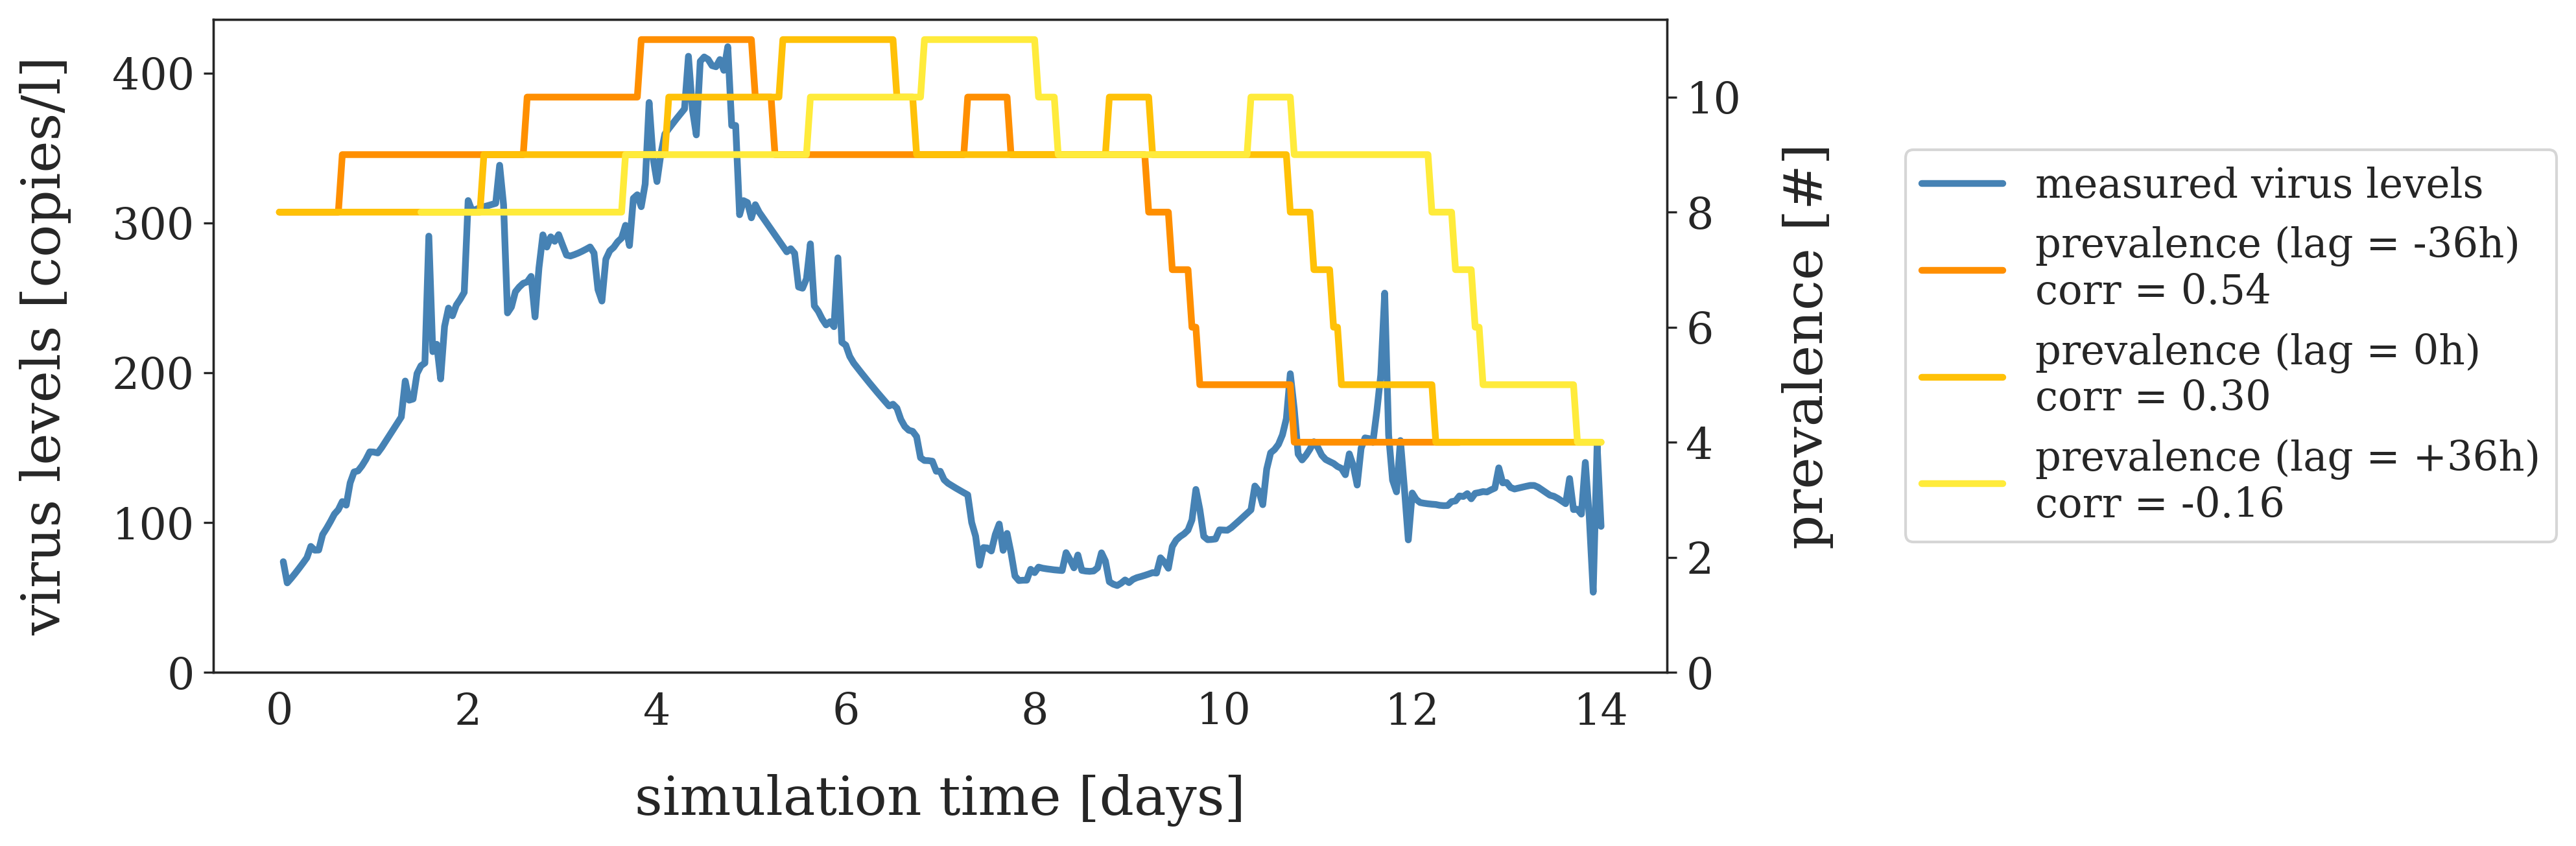

In [91]:
shades_of_yellow = ['#FFEB3B', '#FFC107', '#FF8F00']

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize = (14,4.6), dpi=300)

# Plot copies/l on primary y-axis
sns.lineplot(x=df_wastewater_sub["time_in_days"], y=df_wastewater_sub["COVID_copies/l"], label=f"measured virus levels", ax=ax1, color='steelblue', legend=False, linewidth=2.5)
ax1.set_ylabel('virus levels [copies/l]', labelpad=15,fontsize=20)#, color='steelblue')
ax1.tick_params(axis='y')#, labelcolor='b')
ax1.set_ylim(ymin=0)

# Create secondary y-axis for prevalence
ax2 = ax1.twinx()
# minus lag
df_prevalence_sub = df_prevalence_sim1.loc[(df_prevalence_sim1["time_in_days_minus_lag"] >= min_time) & (df_prevalence_sim1["time_in_days_minus_lag"] <= max_time)]
sns.lineplot(x=df_prevalence_sub["time_in_days_minus_lag"], y=df_prevalence_sub["I_total"], label=f"prevalence (lag = -{lag}h)\ncorr = {correlations[0]:.2f}", ax=ax2, color=shades_of_yellow[2], linewidth=2.5)# 'lightcoral')
# no lag
sns.lineplot(x=df_prevalence_sim1["time_in_days"], y=df_prevalence_sim1["I_total"], label=f"prevalence (lag = 0h)\ncorr = {correlations[1]:.2f}", ax=ax2, color=shades_of_yellow[1], linewidth=2.5)#'indianred')
# plus lag
df_prevalence_sub = df_prevalence_sim1.loc[(df_prevalence_sim1["time_in_days_plus_lag"] >= min_time) & (df_prevalence_sim1["time_in_days_plus_lag"] <= max_time)]
sns.lineplot(x=df_prevalence_sub["time_in_days_plus_lag"], y=df_prevalence_sub["I_total"], label=f"prevalence (lag = +{lag}h)\ncorr = {correlations[2]:.2f}", ax=ax2, color=shades_of_yellow[0], linewidth=2.5)# 'lightcoral')

# Customize secondary y-axis
ax2.set_ylabel('prevalence [#]', labelpad=15,fontsize=20)#, color='indianred')
ax2.tick_params(axis='y')
ax2.set_ylim(ymin=0)

# ax1.annotate(
#     "lag", 
#     xy=(5, 9.104), 
#     xytext=(3, 100),
#     arrowprops=dict(facecolor='black', shrink=0.05, headwidth=8, width=10)
# )

# Draw arrow
#arrow_x = 9.5
#arrow_y = df_prevalence_sim1.loc[df_prevalence_sim1["time_in_days"]==arrow_x, "I_total"].iloc[0]
#offset = lag/24  # Example offset for the arrow
#head_length = 0.35
#ax2.arrow(arrow_x, arrow_y, offset-head_length-0.01, 0, head_width=0.2, head_length=head_length, fc='black', ec='black', zorder=5)
#ax2.arrow(arrow_x + (offset), arrow_y, -(offset-head_length-0.01), 0, head_width=0.3, head_length=head_length, fc='black', ec='black', zorder=5)
#ax2.annotate("time lag", xy=(arrow_x + offset + head_length, arrow_y-0.11), fontsize=16)
#ax2.annotate("0", xy=(arrow_x - (head_length + 0.3) + 0.1, arrow_y-0.11), fontsize=16)

# Customize x-axis
ax1.set_xlabel('simulation time [days]', labelpad=15,fontsize=20)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5), frameon=True)

ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Adjust layout and save figure
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_trajectories_station_{sampling_location}_one_sim.png"), dpi=300)

##### Cross correlation based on average values

In [92]:
from matplotlib.patches import Rectangle

In [114]:
max_lag = 45

df_res = pd.DataFrame()
df_res["lag_in_h"] = range(-max_lag, max_lag+1, 1)

df_nas = pd.DataFrame()
df_nas["sampling_point"] = df_wastewater["sampling_point"].unique()

for sampling_location in df_wastewater["sampling_point"].unique():
    
    df_corr = pd.DataFrame()
    df_corr["lag_in_h"] = range(-max_lag, max_lag+1, 1)
    
    for sim in df_prevalence['memilio_id'].unique():
        curr_sim_ww = df_wastewater.loc[df_wastewater['memilio_id'] == sim]
        curr_sim_prev = df_prevalence.loc[df_prevalence['memilio_id'] == sim]
        curr_combined = curr_sim_ww.merge(curr_sim_prev, left_on="hours", right_on="time", how="left")
        df_corr[sim] = get_crosscorr_for_one_station(curr_combined, sampling_location, df_corr["lag_in_h"])
    
    df_res[sampling_location] = df_corr.loc[:, df_corr.columns != 'lag_in_h'].mean(axis = 1)
    df_nas[sampling_location] = 250 - sum(df_corr.loc[:, df_corr.columns != 'lag_in_h'].isna().sum() > 0)
    
df_res = df_res.set_index("lag_in_h")
df_res.head()


/Users/karinawallrafen/Documents/GitHub/inside_demonstrator/venv/lib/python3.9/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/Users/karinawallrafen/Documents/GitHub/inside_demonstrator/venv/lib/python3.9/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/Users/karinawallrafen/Documents/GitHub/inside_demonstrator/venv/lib/python3.9/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/Users/karinawallrafen/Documents/GitHub/inside_demonstrator/venv/lib/python3.9/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/Users/karinawallrafen/Docum

,10,15,9,11,3,8,14,1,4,16,12,13,6,5,7,2
lag_in_h,,,,,,,,,,,,,,,,
-45,0.181694,0.296901,0.146162,0.069116,0.186388,0.384584,0.412376,0.132843,0.272714,0.479520,0.391113,0.102347,0.040911,0.253902,0.376455,0.185233
-44,0.185763,0.300039,0.149940,0.069871,0.190653,0.388611,0.416543,0.137578,0.276882,0.485079,0.395122,0.104608,0.043497,0.258060,0.380401,0.189035
-43,0.188978,0.302732,0.153065,0.070942,0.193394,0.391836,0.419930,0.141203,0.279439,0.489885,0.398169,0.106865,0.045800,0.261553,0.383563,0.191432
-42,0.191167,0.305197,0.155414,0.072328,0.194718,0.394904,0.423122,0.144020,0.281018,0.494578,0.401077,0.108989,0.048371,0.263849,0.386229,0.192681
-41,0.192284,0.307626,0.156963,0.074744,0.194318,0.397150,0.426025,0.145153,0.281294,0.498843,0.403366,0.111056,0.050427,0.265389,0.388055,0.192404


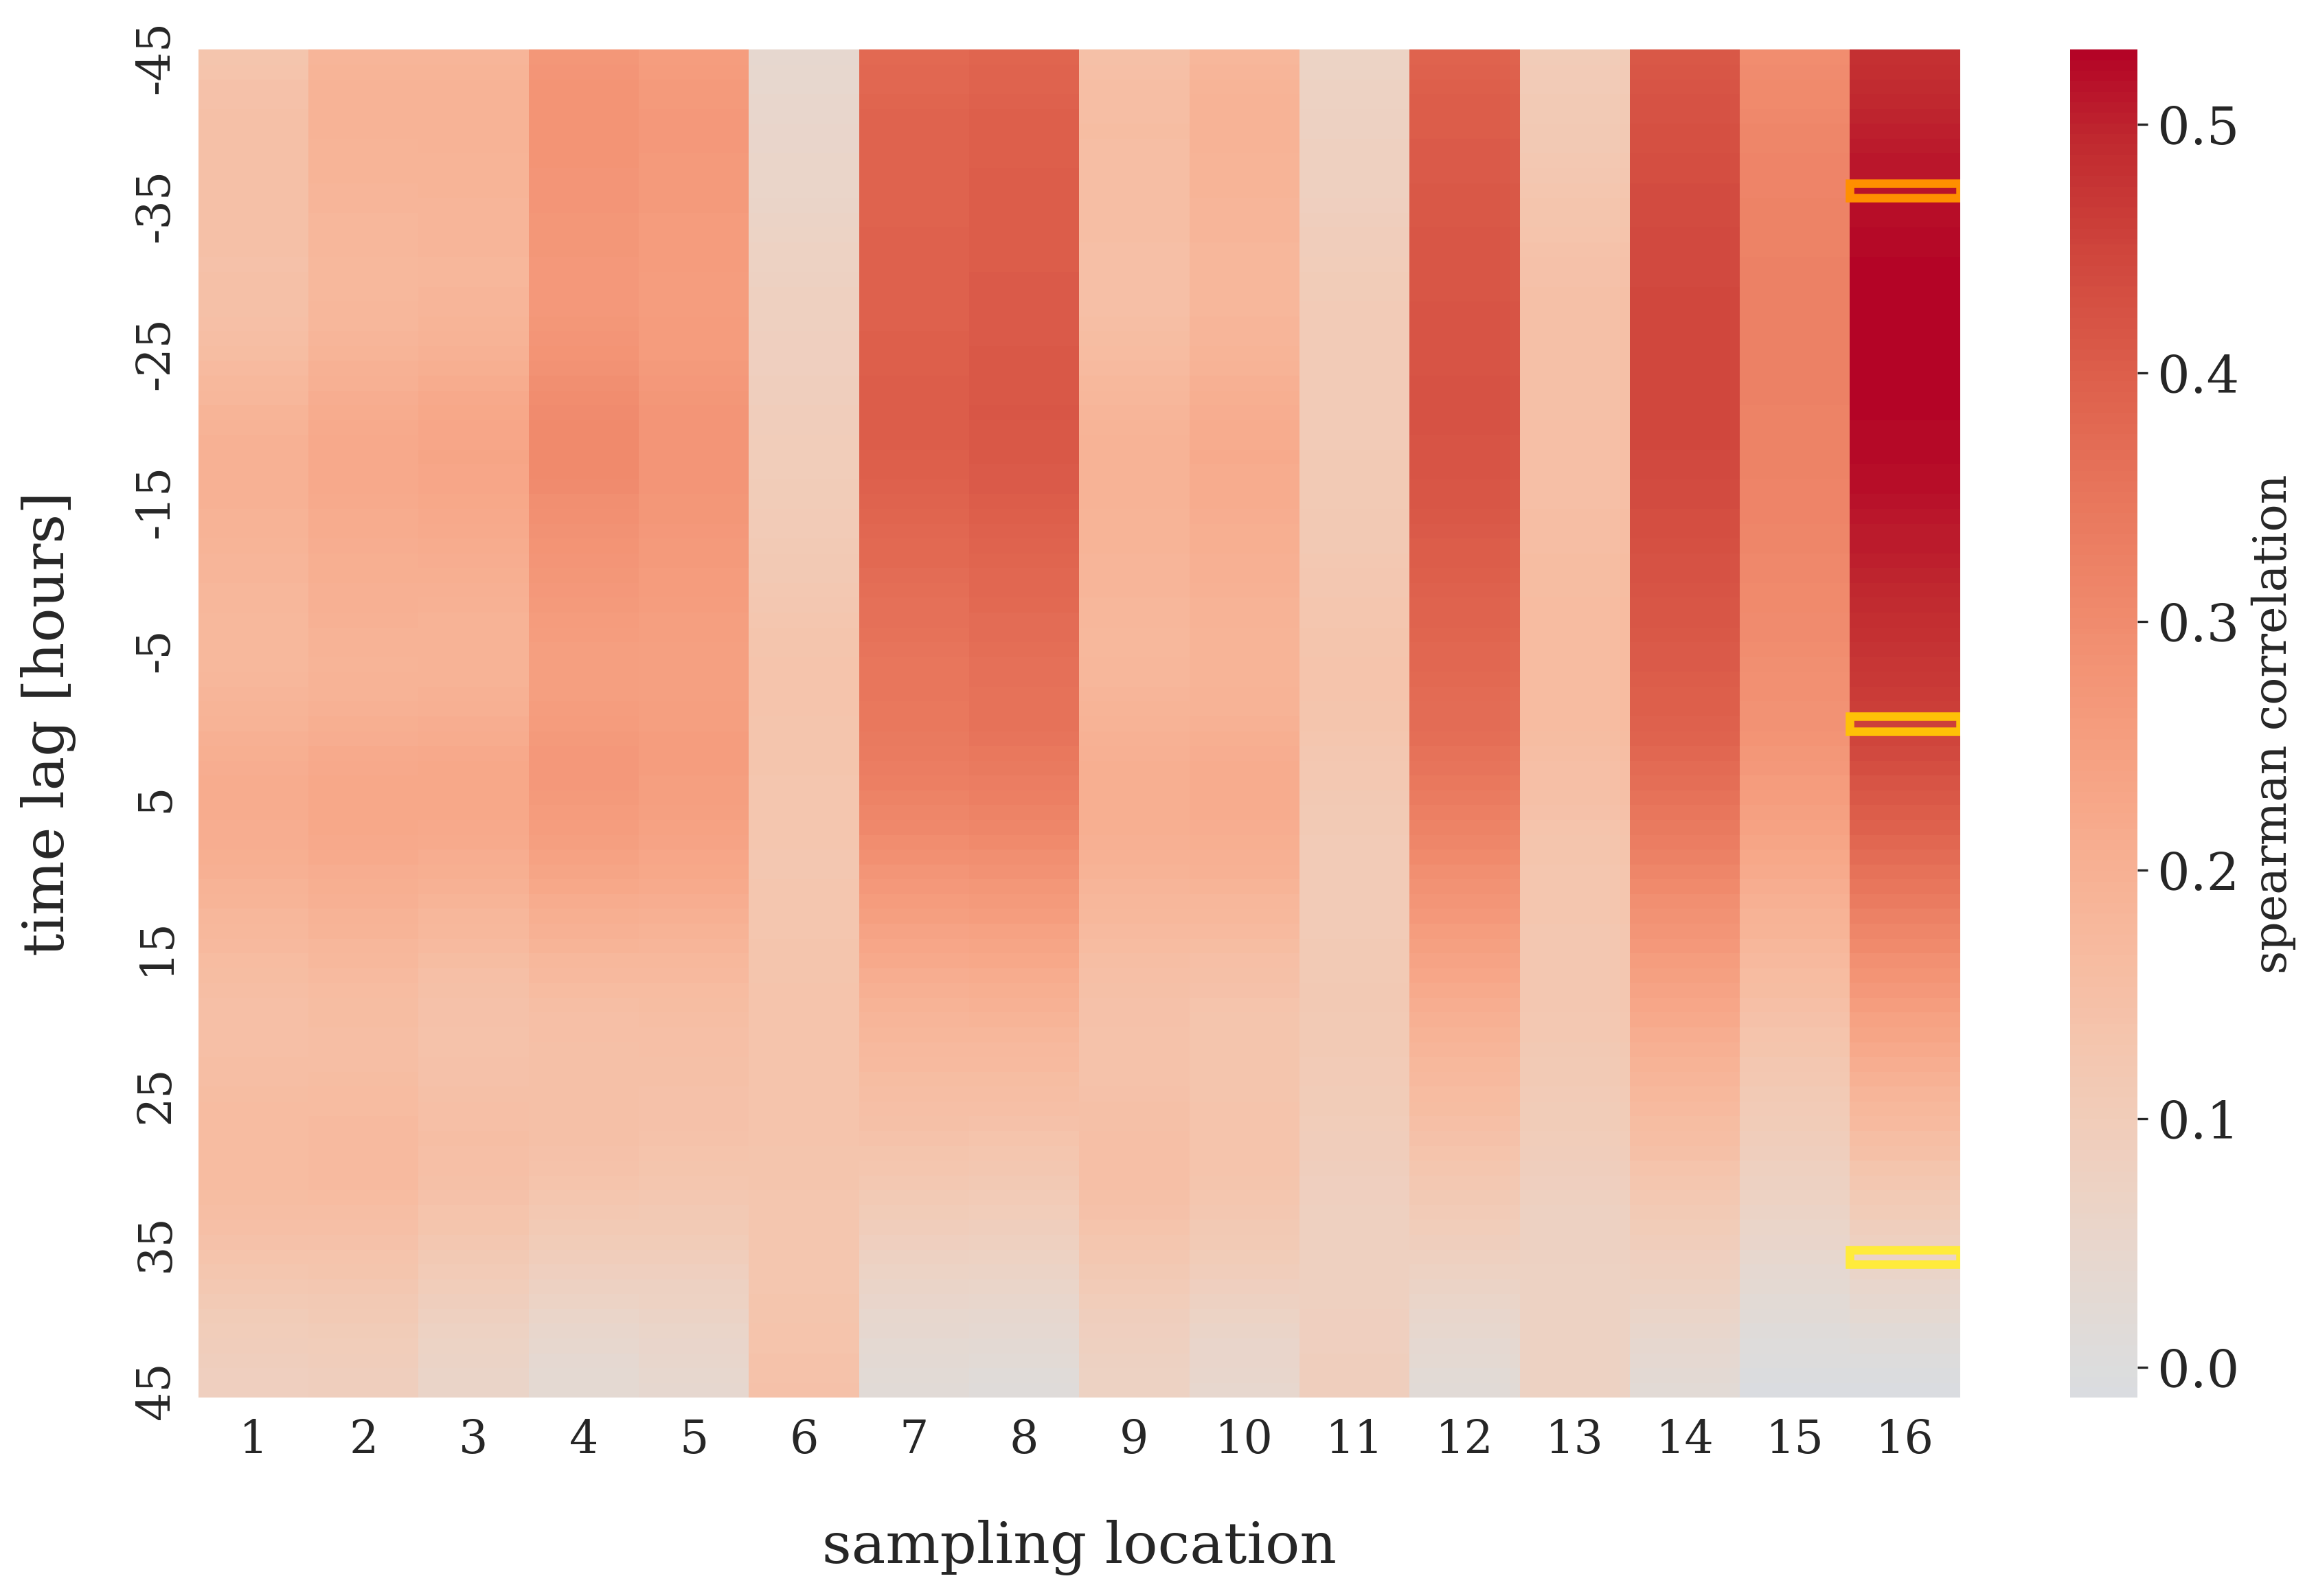

In [115]:
fig, ax = plt.subplots(figsize = (12,8), dpi=300) 
# plt.title("Cross-Correlation between Copies/l and Prevalence")
lb = sns.heatmap(df_res[[str(i) for i in range(1,17)]], cmap='coolwarm', center=0, yticklabels=10, cbar_kws={'label': 'spearman correlation'})
# sns.set(font_scale=1)
#ax.set_title("Cross-Correlation between Copies/l and Prevalence", pad=20)# ,fontsize=20)
ax.set_xlabel("sampling location", labelpad=20,fontsize=20)
ax.set_ylabel("time lag [hours]", labelpad=20,fontsize=20)
lb.figure.axes[-1].yaxis.label.set_size(16)
lb.figure.axes[-1].tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

lag = 36
shades_of_yellow = ['#FFEB3B', '#FFC107', '#FF8F00']
ax.add_patch(Rectangle((15, df_res.index.get_loc(-lag)), 1, 1, fill=False, edgecolor=shades_of_yellow[2], lw=3))
ax.add_patch(Rectangle((15, df_res.index.get_loc(0)), 1, 1, fill=False, edgecolor=shades_of_yellow[1], lw=3))
ax.add_patch(Rectangle((15, df_res.index.get_loc(lag)), 1, 1, fill=False, edgecolor=shades_of_yellow[0], lw=3))

plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_cross_correlation.png"), dpi=300)

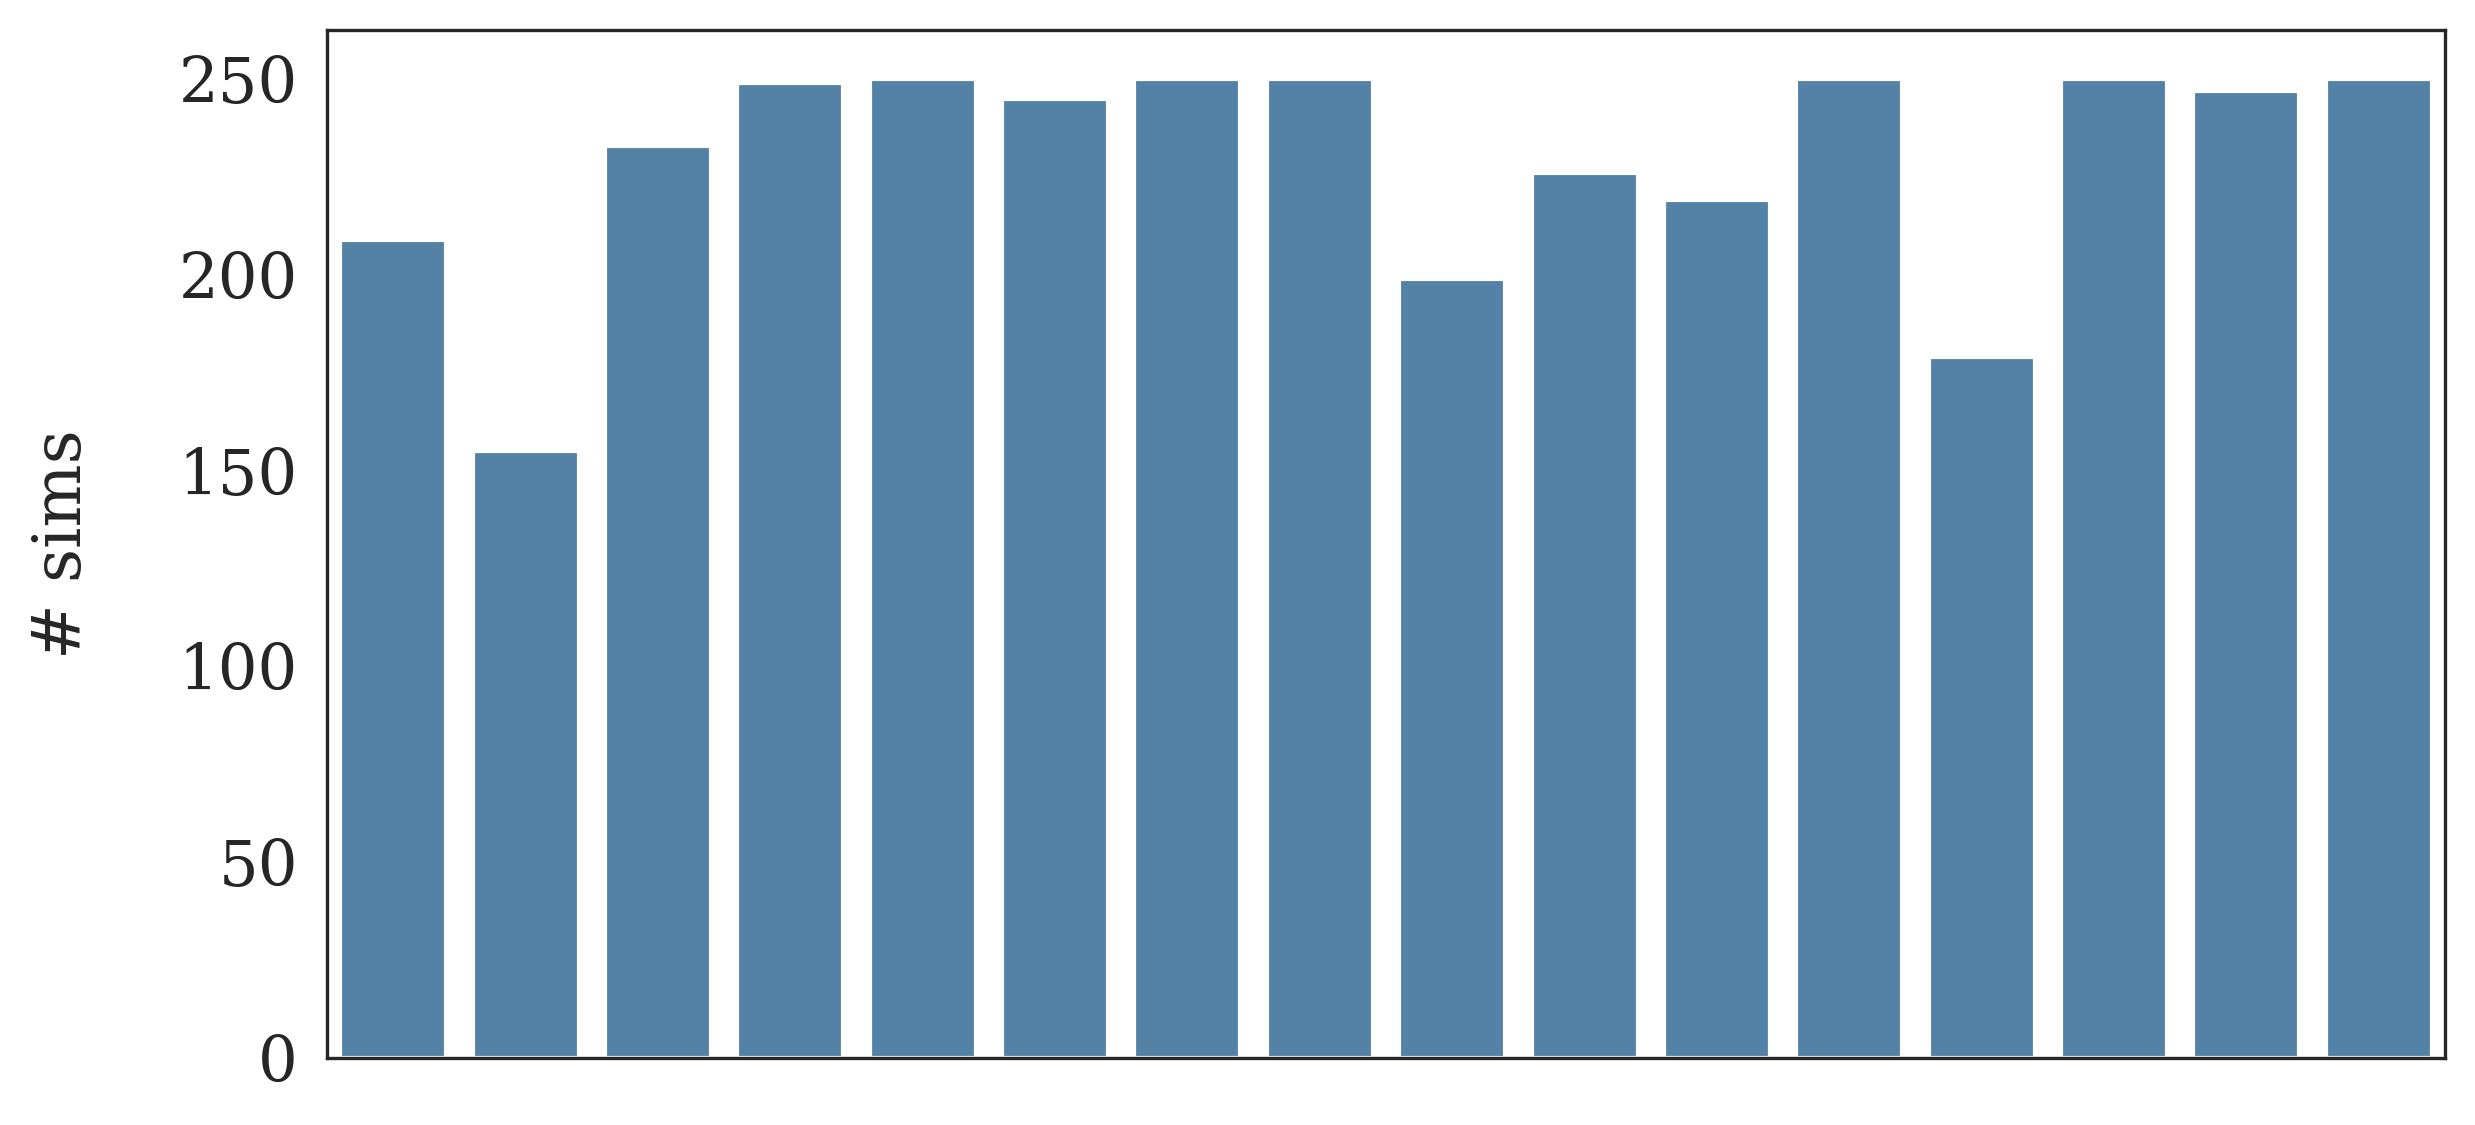

In [127]:
df_nas.to_csv("test.csv")

fig, ax = plt.subplots(figsize = (8.5,4), dpi=300) 
lb = sns.barplot(df_nas[[str(i) for i in range(1,17)]], color = "steelblue")
ax.set_ylabel("# sims", labelpad=20,fontsize=20)
lb.figure.axes[-1].yaxis.label.set_size(16)
#lb.figure.axes[-1].tick_params(axis='y', labelsize=18)
#ax.tick_params(axis='y', labelsize=16)
ax.set(xticklabels=[])

plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_corr_sims.png"), dpi=300)